# Two-Moons CALAS

In this notebook, we will make the first ever attempt to train a <u>**CALAS**</u> model.

In a CALAS model, we split the forward pass into two steps.

In the first step, we do this:

* Forward our nominal data through the chosen representation and embed it in a suitable space.
* Then, we estimate the entropy of the embedded data under the *current* model.

In the second step:

* Permute the nominal embedded data in such a way that its entropy becomes *deliberately* too small or too large under the current model.
* Forward both the nominal embedded data and the permuted data and compute a loss under a contrastive or conditional model (where the nominal data is assigned a different class than the modified data).

We have a `CalasFlow`, which is a conditional Normalizing Flow.
While we cannot directly modify the entropy of data, we can modify its likelihood.
For a normalizing flow with a (quasi-standard) normal base distribution, entropy is approximately anti-proportional to likelihood.

___________



In [1]:
SEED = 1

import __init__
import torch

from calas.models.flow import CalasFlowWithRepr
from calas.models.flow_test import make_flows
from calas.models.repr import AE_UNet_Repr

torch.manual_seed(SEED)

repr = AE_UNet_Repr(input_dim=2, hidden_sizes=(32,8,32))
flow = CalasFlowWithRepr(num_classes=2, repr=repr, flows=make_flows(K=8, dim=repr.embed_dim, units=128, layers=2))

In [2]:
from calas.tools.two_moons import two_moons_rejection_sampling

train_data = two_moons_rejection_sampling(nsamples=25_000, seed=SEED)
train_clz = torch.full(size=(train_data.shape[0],), fill_value=0.)

# Controlled And Linear Anomaly Synthesis

Now that we have defined our model and the **in-distribution** data, we will need to define how exactly we are going to synthesize anomalies.

We will treat the problem in this notebook as an unsupervised anomaly detection problem: Points that fall within any of the two moons are considered in-distribution.
However, we do not have any explicit out-of-distribution data.
In CALAS, the idea is synthesize <u>***near in-distribution outliers***</u>.
During training, those shall be used to <u>***concretize the manifold***</u> of the in-distribution data.

For each batch of nominal data, we will synthesize another batch of same size that is derived from the nominal data (i.e., not just random noise).
The synthesis shall produce data that is very close to the nominal data.

For a sample of $N$ nominal observations, we will produce $N/2$ observations, each having a likelihood that is smaller than the minimum observed likelihood in the nominal batch, and $N/2$ observations that have a likelihood that is larger.

______________


In [3]:
from calas.data.synthesis import Synthesis
from calas.data.permutation import Space, Likelihood, Data2Data_Grad, CurseOfDimDataPermute, Normal2Normal_NoGrad, Normal2Normal_Grad

# We will define two different Synthesis strategies; one to create samples of
# lower likelihood, and one to create samples with higher likelihood. In either
# case the space we're gonna modify in will always be E here.

space = Space.Embedded

# synthesis_both = Synthesis(flow=flow, space_in=space, space_out=space)
# synthesis_both.add_permutations(
#     Data2Data_Grad(flow=flow, space=space, u_min=0.1, u_max=0.15),
#     CurseOfDimDataPermute(flow=flow, space=space, num_dims=(5,15), use_grad_dir=False)
# )

# synthesis_lower = synthesis_both
# synthesis_higher = synthesis_both

synthesis_lower = Synthesis(flow=flow, space_in=space, space_out=space)
synthesis_lower.add_permutations(
    Data2Data_Grad(flow=flow, space=space, seed=SEED),
    CurseOfDimDataPermute(flow=flow, space=space, seed=SEED),
    Normal2Normal_NoGrad(flow=flow, method='quantiles', use_loc_scale_base_grad=True)
)


synthesis_higher = Synthesis(flow=flow, space_in=space, space_out=space)
synthesis_higher.add_permutations(
    Normal2Normal_Grad(flow=flow, method='quantiles', u_min=0.01, seed=SEED),
    CurseOfDimDataPermute(flow=flow, space=space, u_min=0.001, u_max=0.01, u_frac_negative=0.5, seed=SEED),
    Data2Data_Grad(flow=flow, space=space, seed=SEED)
)

# Split-Step Training

We will perform "split-step" training.
Instead of just forwarding the data and computing the loss, we will perform the two steps manually.

*NOTE*: The representation will also learn to reconstruct the counter-examples, **unless** we clone/detach the nominal sample prior to modifying it.
I added a boolean flag in the next block so this can be controlled.

_____


In [4]:
REPR_LEARN_COUNTER = True

from warnings import warn
from torch import Tensor, nn, cuda, device

assert cuda.is_available(), "Don't do this on CPU..."
dev = device('cuda:0')

def split_step_forward(nominal_batch: Tensor, nominal_classes: Tensor) -> Tensor:
    """
    Takes as input a batch of nominal data, produces the counter examples,
    forwards both with appropriate conditions, and returns the computed loss
    as a tensor, on which we can call `backward()`.
    """
    flow.eval()
    assert not flow.training and not repr.training
    nominal_batch = nominal_batch.to(device=dev)
    nominal_classes = torch.atleast_1d(nominal_classes.squeeze().to(device=dev, dtype=torch.int64))
    num_nominal = nominal_batch.shape[0]


    # First: Forward the data through the representation!
    nominal_E = flow.X_to_E(input=nominal_batch)

    # Second: Optionally detach nominal data from gradient computation!
    nominal_E = nominal_E.clone()
    clz = nominal_classes.clone()
    if not REPR_LEARN_COUNTER:
        nominal_E.detach_()
        clz.detach_()
    
    # Third: Determine the nominal data's likelihood under the current model.
    nominal_likelihoods: Tensor = None
    with torch.no_grad():
        nominal_likelihoods = flow.log_rel_lik_E(embeddings=nominal_E, classes=clz)
    

    # Fourth: Set the desired lower/higher likelihoods. We will also set critical
    # values beyond which a permutation is considered too good/bad.
    lik_min, lik_max, lik_sd =\
        nominal_likelihoods.min(), nominal_likelihoods.max(), nominal_likelihoods.std()
    target_lower, target_lower_critical = lik_min - 5*lik_sd, lik_min - 15*lik_sd
    target_higher, target_higher_critical = lik_max + 5*lik_sd, lik_max + 15*lik_sd


    # Fifth step: Synthesis. We will request synthesization of more samples than
    # we need, because sometimes it is difficult for the synthesis to modify all
    # samples in a batch.
    sample_lower_E = synthesis_lower.synthesize(sample=nominal_E, classes=clz, target_lik=target_lower, target_lik_crit=target_lower_critical, likelihood=Likelihood.Decrease, max_steps=8)[0]
    num_lower = sample_lower_E.shape[0]
    sample_higher_E = synthesis_higher.synthesize(sample=nominal_E, classes=clz, target_lik=target_higher, target_lik_crit=target_higher_critical, likelihood=Likelihood.Increase, max_steps=8)[0]
    num_higher = sample_higher_E.shape[0]

    if num_lower < (num_nominal // 2):
        warn(f'Only produced {num_lower} lower-likelihood samples out of {num_nominal}.')
    if num_higher < (num_nominal // 2):
        warn(f'Only produced {num_higher} higher-likelihood samples out of {num_nominal}.')
    
    other_E = torch.vstack(tensors=(
        sample_lower_E[0:min(num_nominal // 2, num_lower)],
        sample_higher_E[0:min(num_nominal // 2, num_higher)]))
    other_clz = torch.full(size=(other_E.shape[0],), fill_value=1., device=clz.device)

    if (num_lower + num_higher) < num_nominal:
        # Make sure we have the same number of nominal / other samples.
        nominal_E = nominal_E[0:other_E.shape[0]]
        clz = clz[0:other_E.shape[0]]
    

    # Sixth step: Compute the Loss!
    flow.train()
    loss = flow.loss_wrt_E(embeddings=torch.vstack(
        tensors=(nominal_E, other_E)
    ), classes=torch.cat(tensors=(clz, other_clz)))
    return loss

In [5]:
# flow.to(dev)
# split_step_forward(train_data[0:10], train_clz[0:10])

# Training

In [6]:
EPOCHS = 100
BATCH_SIZE = 4

flow.to(device=dev)
optim = torch.optim.Adam(params=flow.parameters(recurse=True), lr=5e-4)
steps = 0
loss_before = float('inf')

while steps < EPOCHS:
    steps += 1
    optim.zero_grad()

    perm = torch.randperm(train_data.shape[0])
    batch = train_data[perm[0:BATCH_SIZE]]
    batch_clz = train_clz[perm[0:BATCH_SIZE]]

    loss = split_step_forward(nominal_batch=batch, nominal_classes=batch_clz)
    loss.backward()
    optim.step()

    print(f'Loss: {loss.item()}')

/tmp/ipykernel_4051/1017173217.py:57: UserWarning: Only produced 0 higher-likelihood samples out of 4.
  warn(f'Only produced {num_higher} higher-likelihood samples out of {num_nominal}.')


Loss: 1235.9310302734375
Loss: 356.2210693359375


/tmp/ipykernel_4051/1017173217.py:55: UserWarning: Only produced 1 lower-likelihood samples out of 4.
  warn(f'Only produced {num_lower} lower-likelihood samples out of {num_nominal}.')
/tmp/ipykernel_4051/1017173217.py:57: UserWarning: Only produced 1 higher-likelihood samples out of 4.
  warn(f'Only produced {num_higher} higher-likelihood samples out of {num_nominal}.')


Loss: 1013.3724365234375


/tmp/ipykernel_4051/1017173217.py:55: UserWarning: Only produced 0 lower-likelihood samples out of 4.
  warn(f'Only produced {num_lower} lower-likelihood samples out of {num_nominal}.')


Loss: 113.7673568725586
Loss: nan
Loss: nan
Loss: 246.40682983398438
Loss: 321.3074645996094
Loss: 245.02691650390625
Loss: 200.38278198242188
Loss: 182.86981201171875
Loss: 212.94444274902344
Loss: 181.9073028564453
Loss: 230.85360717773438
Loss: 281.13067626953125
Loss: nan
Loss: nan
Loss: nan
Loss: 250.3428497314453
Loss: 269.209716796875
Loss: 221.78884887695312
Loss: 202.67251586914062
Loss: 193.34878540039062
Loss: 246.41519165039062
Loss: 174.0518798828125
Loss: 168.17539978027344
Loss: 170.79920959472656
Loss: 233.123291015625
Loss: 264.26654052734375
Loss: 219.36412048339844
Loss: 217.08834838867188
Loss: 159.2764434814453
Loss: 218.62167358398438
Loss: 234.62289428710938
Loss: 162.37371826171875
Loss: 146.16226196289062
Loss: 142.76431274414062
Loss: 137.731689453125
Loss: 181.81253051757812
Loss: 143.35604858398438
Loss: 142.64492797851562
Loss: 131.51353454589844
Loss: 120.85956573486328
Loss: 115.82902526855469
Loss: 108.269775390625
Loss: 131.34072875976562
Loss: 95.77117

It looks like the training was relatively stable, except for some hick-ups in the beginning, where for a few steps it was not possible to synthesize sufficiently many counter examples.
Also, I have not skipped training steps where the loss was NaN.

__________


# Evaluation

We will do the following:

* Generate some new (in-distribution) data from the two moons problem and check its likelihood under the correct (0) and wrong (1) class.
* Generate some ***complementary*** data from the two moons problem and check how well the score distinguishes it.

In the latter case, we would ideally like to see the flow to systematically assign lower (close to zero) likelihoods to the complementary data.

In [12]:
flow.eval()

test_id = two_moons_rejection_sampling(nsamples=5_000, seed=SEED+1).to(device=dev)
test_id_clz = torch.full(size=(test_id.shape[0],), fill_value=0., device=dev)

# Note that we have not trained with pure+tight moons so this won't be perfect
# because the data we trained on will bleed a little into the complementary data.
test_comp = two_moons_rejection_sampling(nsamples=5_000, seed=SEED+1, complementary=True, pure_moons=True, pure_moons_mode='tight').to(device=dev)
test_comp_clz = torch.full(size=(test_comp.shape[0],), fill_value=1., device=dev)

In [17]:
flow.log_rel_lik_X(input=test_id[0:500], classes=test_id_clz[0:500]).mean()

tensor(-105.1189, device='cuda:0', grad_fn=<MeanBackward0>)

In [18]:
flow.log_rel_lik_X(input=test_id[0:500], classes=test_comp_clz[0:500]).mean()

tensor(-114.4144, device='cuda:0', grad_fn=<MeanBackward0>)

In [19]:
flow.log_rel_lik_X(input=test_comp[0:500], classes=test_comp_clz[0:500]).mean()

tensor(-116.2561, device='cuda:0', grad_fn=<MeanBackward0>)

In [20]:
flow.log_rel_lik_X(input=test_comp[0:500], classes=test_id_clz[0:500]).mean()

tensor(-111.4242, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
def likelihood_score(data: Tensor) -> Tensor:
    with torch.no_grad():
        clz_0 = torch.zeros(size=(data.shape[0],), device=data.device)
        clz_1 = torch.ones(size=(data.shape[0],), device=data.device)
        
        return flow.eval().log_rel_lik_X(data, clz_0) - flow.eval().log_rel_lik_X(data, clz_1)

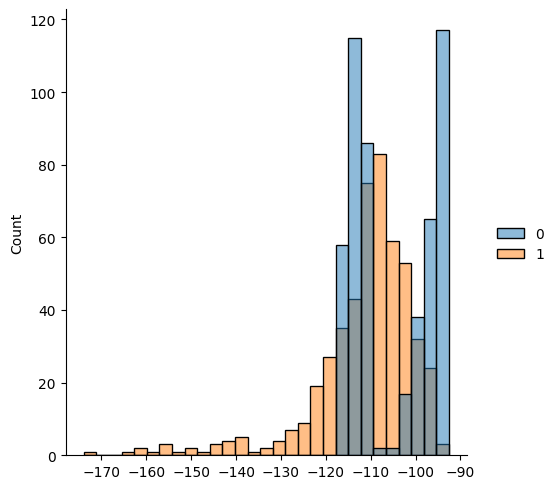

In [31]:
import seaborn as sns

sns.displot(data=torch.vstack(tensors=(
    likelihood_score(test_id),
    likelihood_score(test_comp)
)).T.detach().cpu().numpy())

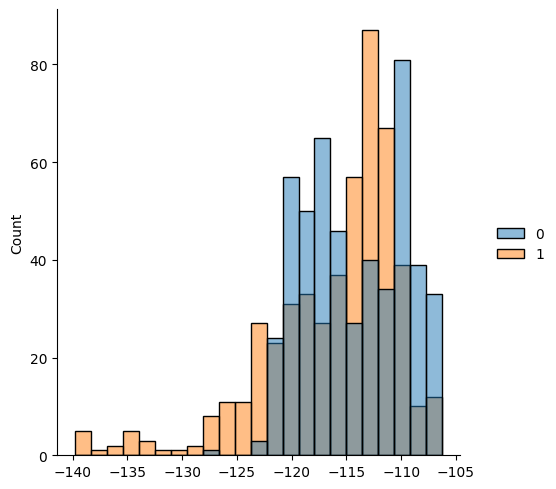

In [32]:

sns.displot(data=torch.vstack(tensors=(
    flow.log_rel_lik_X(input=test_id[0:500], classes=test_comp_clz[0:500]),
    flow.log_rel_lik_X(input=test_comp[0:500], classes=test_comp_clz[0:500])
)).T.detach().cpu().numpy())

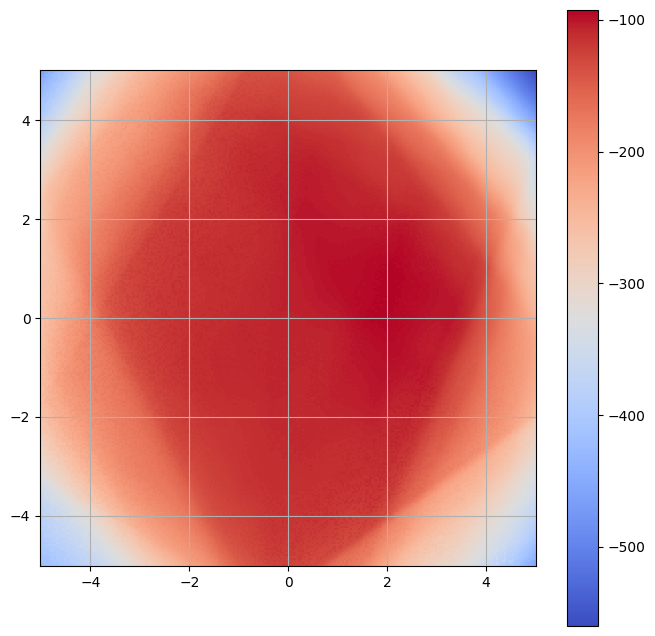

In [33]:
import matplotlib.pyplot as plt

grid_size = 250
xx, yy = torch.meshgrid(torch.linspace(-5, 5, grid_size), torch.linspace(-5, 5, grid_size), indexing='ij')
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(dev)

probs = flow.log_rel_lik_X(input=zz, classes=torch.zeros(zz.shape[0], device=dev))
p_target = probs.view(*xx.shape).cpu().data.numpy()

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, p_target, shading='auto', cmap='coolwarm')#, vmin=likelihood.min().item(), vmax=likelihood.max().item())
plt.gca().set_aspect('equal', 'box')
plt.grid(visible=True)
plt.colorbar()
plt.show()

optimal_threshold=inf, roc_auc_score=0.1877


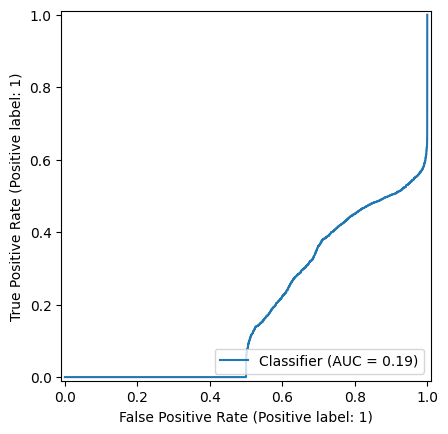

In [40]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay

with torch.no_grad():
    y_true = np.concatenate((np.zeros(test_id.shape[0]), np.ones(test_comp.shape[0])))
    y_pred = flow.log_rel_lik_X(input=torch.cat((test_id, test_comp)), classes=torch.cat((test_id_clz, test_comp_clz))).detach().cpu().numpy()

    fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_pred)
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    optimal_threshold = thresholds[optimal_idx]
    print(f'optimal_threshold={optimal_threshold:.4f}, roc_auc_score={roc_auc_score(y_true=y_true, y_score=y_pred):.4f}')

    RocCurveDisplay.from_predictions(y_true=y_true, y_pred=y_pred)

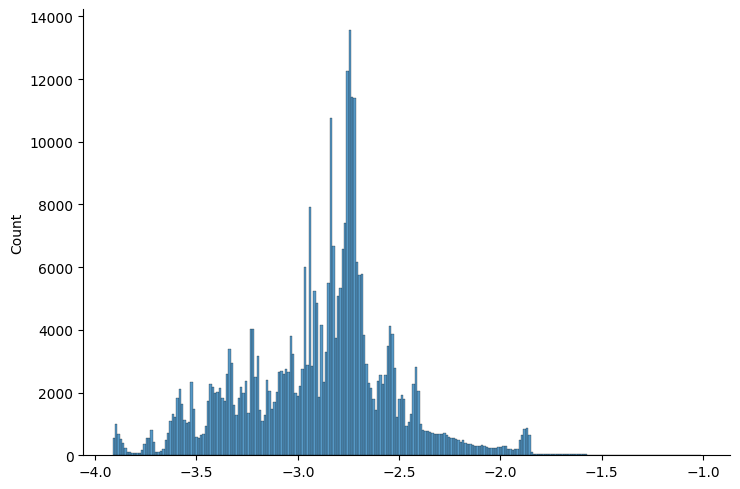

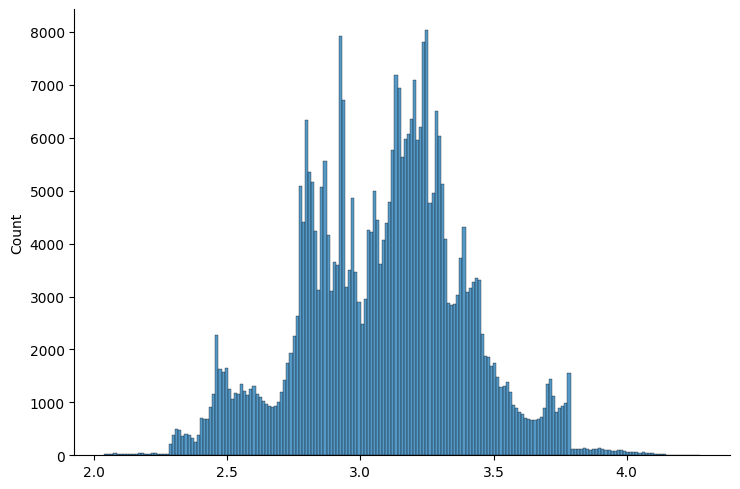

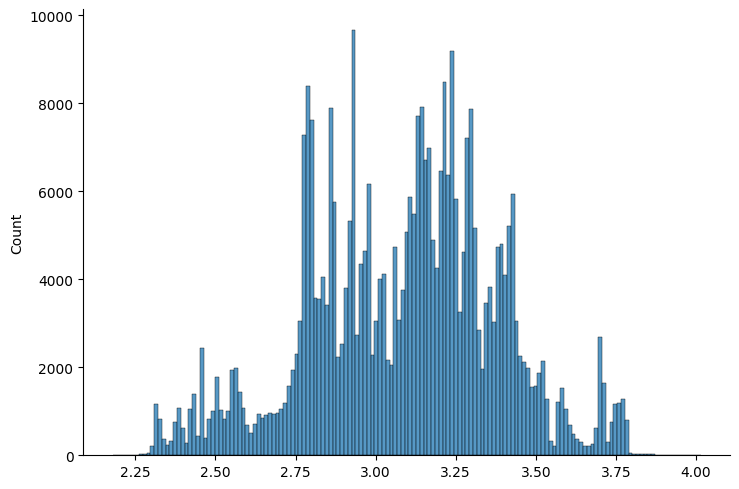

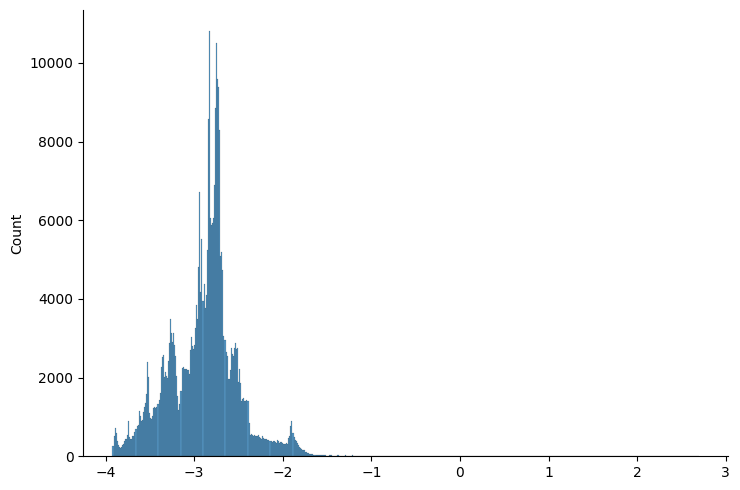

In [44]:
# These are correctly forwarded, i.e., the classes match!
with torch.no_grad():
    b_id = flow.X_to_B(test_id, test_id_clz)[0].flatten()
    b_comp = flow.X_to_B(test_comp, test_comp_clz)[0].flatten()

    # Same, but mixed-up classes!
    b_id_wrong = flow.X_to_B(test_id, test_comp_clz)[0].flatten()
    b_comp_wrong = flow.X_to_B(test_comp, test_id_clz)[0].flatten()

    aspect = 1.5
    sns.displot(b_id.detach().cpu().numpy(), aspect=aspect)
    sns.displot(b_comp.detach().cpu().numpy(), aspect=aspect)
    sns.displot(b_id_wrong.detach().cpu().numpy(), aspect=aspect)
    sns.displot(b_comp_wrong.detach().cpu().numpy(), aspect=aspect)